### This script relies on a active environment with Basemap
If that is not possible, you properly have to outcomment a thing or two.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import ezodf

In [3]:
airports_1 = gpd.read_file('../Data Sources/Global Airports Shapefile (1)/ne_10m_airports.shp')
countries = gpd.read_file('../Data Sources/countries (1)/ne_50m_admin_0_countries.shp').fillna(value='None')

# Airports
### Let's have a look at the shapefile

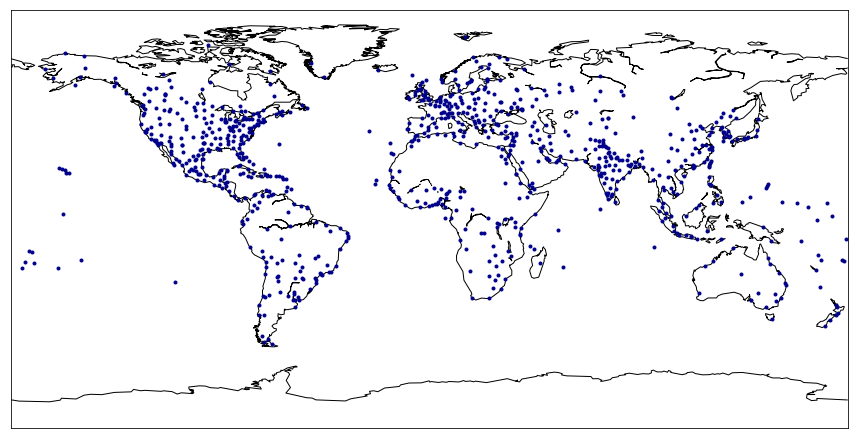

In [4]:
##### Visualising the airports
plt.figure(figsize=(15,15))
map = Basemap()
map.drawcoastlines()

for airport in airports_1.index:
    map.plot(list(airports_1.loc[airport].geometry.coords)[0][0],
            list(airports_1.loc[airport].geometry.coords)[0][1],color='darkblue',marker='o',markersize=3)

plt.show()

### Berief descriptive statistics of the shapfile

In [5]:
airports_1.shape

(891, 36)

In [6]:
airports_1.columns

Index(['scalerank', 'featurecla', 'type', 'name', 'abbrev', 'location',
       'gps_code', 'iata_code', 'wikipedia', 'natlscale', 'comments',
       'wikidataid', 'name_ar', 'name_bn', 'name_de', 'name_en', 'name_es',
       'name_fr', 'name_el', 'name_hi', 'name_hu', 'name_id', 'name_it',
       'name_ja', 'name_ko', 'name_nl', 'name_pl', 'name_pt', 'name_ru',
       'name_sv', 'name_tr', 'name_vi', 'name_zh', 'wdid_score', 'ne_id',
       'geometry'],
      dtype='object')

#### Removing redundant columns

In [7]:
# Removed columns are 'featurecla' (no variation) and all the name-columns in different languages. 
airports = airports_1[['scalerank','type','name','abbrev','location','gps_code','iata_code','wikipedia',\
                      'wdid_score','ne_id','geometry']]

#### We want the airports to have a country classification attach, i.e. a unique ISO_A3 code. This can be done via a spatial join of the airports and the geometries in the country shapefile. However, some of the countries (more like states) in the country-shapefile doesn't not have a ISO_A3 code, which is corrected below.

Alternating the iso codes is needed, because some have a iso_code of -99 (Because it isn't a sovereign state)

http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-details/

https://unstats.un.org/unsd/tradekb/Knowledgebase/Country-Code

### Update: The country-coding-scheme "GU_A3" is used instead of the actuall ISO_A3 codes. See _GlobalAttributes.ipynb_ for a short justification. 

In [8]:
countries.shape

(241, 95)

In [9]:
countries['ISO3'] = countries.GU_A3#np.array(iso_codes).astype('object') 

#### Performing the spatial join

In [10]:
airports = gpd.sjoin(airports,countries, how='left',op = 'within')
airports = airports[['scalerank_left','type','name','abbrev','location','gps_code','iata_code','wikipedia',\
                      'wdid_score','ne_id','geometry','NAME','ISO3']]

In [11]:
airports['type'].unique()

array(['small', 'mid', 'mid and military', 'major and military',
       'military mid', 'military', 'major', 'military major', 'spaceport'],
      dtype=object)

In [12]:
airports[airports['type']=='spaceport']

,scalerank_left,type,name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,NAME,ISO3
277,8,spaceport,Baikonur Cosmodrome,BAIK,approximate,None,None,http://en.wikipedia.org/wiki/Baikonur_Cosmodrome,4,1159118931,POINT (63.30735442387505 45.96357394031237),Kazakhstan,KAZ
278,8,spaceport,Kennedy Space Center,KSC,approximate,None,None,http://en.wikipedia.org/wiki/John_F._Kennedy_S...,4,1159118961,POINT (-80.6369680911892 28.51637047720271),United States of America,USA
279,8,spaceport,Centre Spatial Guyanais,CSG,terminal,None,None,http://en.wikipedia.org/wiki/Guiana_Space_Centre,4,1159118977,POINT (-52.76842968934524 5.239410012580352),France,FRA


In [13]:
dataHolder = [[] for i in np.arange(2)]

for airportType in airports['type']:
    if airportType in ['small','mid','major']:
        
        if airportType=='small':
            dataHolder[1].append('Small')
        elif airportType=='mid':
            dataHolder[1].append('Medium')
        elif airportType=='major':
            dataHolder[1].append('Major')
            
        dataHolder[0].append('Civilian')
    
    elif airportType in ['mid and military','major and military']:
        
        if 'mid' in airportType:
            dataHolder[1].append('Medium')
        elif 'major' in airportType:
            dataHolder[1].append('Major')
        
        dataHolder[0].append('Military/Civilian')
        
    elif airportType == 'spaceport':
        dataHolder[0].append('Spaceport')
        dataHolder[1].append('Medium')
        
    elif airportType in ['military mid','military','military major']:
        
        if 'mid' in airportType:
            dataHolder[1].append('Medium')
        elif 'major' in airportType:
            dataHolder[1].append('Major')
        else:
            dataHolder[1].append('Small')
        
        dataHolder[0].append('Military')

In [14]:
airports['size'] = dataHolder[1]
airports['usage'] = dataHolder[0]
airports = airports.drop(['type'],axis=1)

In [15]:
airports.head()

,scalerank_left,name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,NAME,ISO3,size,usage
0,9,Sahnewal,LUH,terminal,VILD,LUH,http://en.wikipedia.org/wiki/Sahnewal_Airport,4,1159113785,POINT (75.95707224036518 30.85035985617018),India,IND,Small,Civilian
1,9,Solapur,SSE,terminal,VASL,SSE,http://en.wikipedia.org/wiki/Solapur_Airport,4,1159113803,POINT (75.93305977107549 17.62541518363502),India,IND,Medium,Civilian
2,9,Birsa Munda,IXR,terminal,VERC,IXR,http://en.wikipedia.org/wiki/Birsa_Munda_Airport,4,1159113831,POINT (85.32359703687671 23.31772459899619),India,IND,Medium,Civilian
3,9,Ahwaz,AWZ,terminal,OIAW,AWZ,http://en.wikipedia.org/wiki/Ahwaz_Airport,4,1159113845,POINT (48.74710654359313 31.34315855607572),Iran,IRN,Medium,Civilian
4,9,Gwalior,GWL,terminal,VIGR,GWL,http://en.wikipedia.org/wiki/Gwalior_Airport,4,1159113863,POINT (78.21721865463483 26.28548769793701),India,IND,Medium,Military/Civilian


In [16]:
airports.NAME = np.array(airports.NAME.fillna('None'))
airports.ISO3 = np.array(airports.ISO3.fillna('None'))

In [17]:
print('The number of airports with missing country-specification are: ',\
     sum([1 if name == 'None' else 0 for name in airports.NAME]),
     '\nThe total number of airports are: ',airports.shape[0],
     '\nWhich is %.3f percentage of the airports' %((sum([1 if name == 'None' else 0 for name in airports.NAME])\
                                                    /airports.shape[0])*100))

The number of airports with missing country-specification are:  68 
The total number of airports are:  891 
Which is 7.632 percentage of the airports


### Let's investigate airports with missing country-specifications

In [18]:
noCountryAirports = airports[[True if name == 'None' else False for name in airports.NAME]]
noCountryAirports = noCountryAirports.reset_index(drop=True)

In [19]:
noCountryAirports

,scalerank_left,name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,NAME,ISO3,size,usage
0,8,Cocos (Keeling) Islands,CCK,terminal,YPCC,CCK,http://en.wikipedia.org/wiki/Cocos_(Keeling)_I...,4,1159115105,POINT (96.82874721442073 -12.18515859532931),None,None,Medium,Civilian
1,8,Corfu Int'l (Ioannis Kapodistrias),CFU,terminal,LGKR,CFU,http://en.wikipedia.org/wiki/Corfu_Internation...,4,1159115125,POINT (19.91475616416621 39.60675545052586),None,None,Medium,Civilian
2,8,Gerrard Smith,CYB,terminal,MWCB,CYB,http://en.wikipedia.org/wiki/Gerrard_Smith_Int...,4,1159115383,POINT (-79.87946163800297 19.68986539628435),None,None,Medium,Civilian
3,8,Terrance B. Lettsome Int'l,EIS,terminal,TUPJ,EIS,http://en.wikipedia.org/wiki/Terrance_B._Letts...,4,1159115573,POINT (-64.53715143657945 18.44436185579831),None,None,Medium,Civilian
4,8,Gibraltar,GIB,runway,LXGB,GIB,http://en.wikipedia.org/wiki/Gibraltar_Airport,4,1159115799,POINT (-5.346771800333878 36.15127475041734),None,None,Medium,Civilian
5,8,Sumburgh,LSI,runway,EGPB,LSI,http://en.wikipedia.org/wiki/Sumburgh_Airport,2,1159116567,POINT (-1.288060688387535 59.87668995989993),None,None,Medium,Civilian
6,8,Svalbard Longyear,LYR,terminal,ENSB,LYR,http://en.wikipedia.org/wiki/Svalbard_Airport%...,4,1159116623,POINT (15.495229 78.246717),None,None,Medium,Civilian
7,8,Paphos Int'l,PFO,ramp,LCPH,PFO,http://en.wikipedia.org/wiki/Paphos_Internatio...,4,1159116971,POINT (32.48323220649264 34.71340128173351),None,None,Major,Civilian
8,8,Sitka Rocky Gutierrez,SIT,terminal,PASI,SIT,http://en.wikipedia.org/wiki/Sitka_Rocky_Gutie...,4,1159117325,POINT (-135.365692 57.05349),None,None,Medium,Civilian
9,8,Shannon,SNN,terminal,EINN,SNN,http://en.wikipedia.org/wiki/Shannon_Airport,4,1159117403,POINT (-8.922428855576857 52.69345371025317),None,None,Major,Civilian


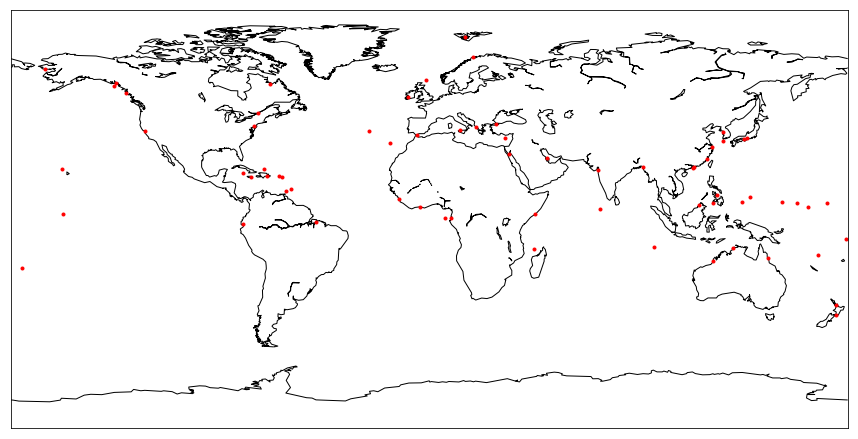

In [20]:
##### Visualising the airports
plt.figure(figsize=(15,15))
map = Basemap()
map.drawcoastlines()

for airport in noCountryAirports.index:
    map.plot(list(noCountryAirports.loc[airport].geometry.coords)[0][0],
            list(noCountryAirports.loc[airport].geometry.coords)[0][1],color='red',marker='o',markersize=3)

plt.show()

The reason for some airports not being assigned as ISO3 code, is because the codes are assigned based on the intersection with the country-polygons. There are two reasons why they don't intersect with the country-shapfile; 

1: Some airports are located on remote islands, which aren't in the country-shapefile.
2: The points of the airports are, from the origin, calculated as the centroid of the airport area, which can apperently lie out in the sea, which implies that it isn't captured by the intersection with the countries.

It is not prioritised at the moment.

## Busiest Airports

In [21]:
busiestAirports = pd.read_csv('../Data Sources/Busiest Airports, Global (1)/Busiest Airports.csv',index_col=3)

In [22]:
busiestAirports

,Rank,City,Country,Loaded/unloaded 2017,Change
Airport,,,,,
HKG,1,HONG KONG,HK,5049898,9.4
MEM,2,MEMPHIS TN,US,4336752,0.3
PVG,3,SHANGHAI,CN,3824280,11.2
ICN,4,INCHEON,KR,2921691,7.6
ANC,5,ANCHORAGE AK,US,2713230,6.7
DXB,6,DUBAI,AE,2654494,2.4
SDF,7,LOUISVILLE KY,US,2602695,6.8
NRT,8,TOKYO,JP,2336427,7.9
TPE,9,TAIPEI,TW,2269585,8.2


In [23]:
dataHolder = [[] for i in np.arange(3)]

for iata in airports.iata_code:
    if iata in list(busiestAirports.index):
        dataHolder[0].append(1)
        dataHolder[1].append(busiestAirports['Rank'].loc[iata])
        dataHolder[2].append(busiestAirports['Loaded/unloaded 2017'].loc[iata])
        
    else:
        dataHolder[0].append(0)
        dataHolder[1].append(0)
        dataHolder[2].append(0)

In [24]:
airports['top_20_busiest_airports'] = dataHolder[0]
airports['busiest_airport_ranking'] = dataHolder[1]
airports['amount_passed_through'] = dataHolder[2]

In [25]:
airports['ISO3'].loc[list(airports[airports.busiest_airport_ranking==1].index)[0]] = 'HKG'
airports['NAME'].loc[list(airports[airports.busiest_airport_ranking==1].index)[0]] = 'Hong Kong'
airports['ISO3'].loc[list(airports[airports.busiest_airport_ranking==3].index)[0]] = 'CHN'
airports['NAME'].loc[list(airports[airports.busiest_airport_ranking==3].index)[0]] = 'China'
airports['ISO3'].loc[list(airports[airports.busiest_airport_ranking==4].index)[0]] = 'KOR'
airports['NAME'].loc[list(airports[airports.busiest_airport_ranking==4].index)[0]] = 'South Korea'

C:\Users\Krist\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Lower casing all column names

In [26]:
airports.columns

Index(['scalerank_left', 'name', 'abbrev', 'location', 'gps_code', 'iata_code',
       'wikipedia', 'wdid_score', 'ne_id', 'geometry', 'NAME', 'ISO3', 'size',
       'usage', 'top_20_busiest_airports', 'busiest_airport_ranking',
       'amount_passed_through'],
      dtype='object')

In [27]:
cols = airports.columns
airports.columns = [cols[0]] + ['airport_name']+list(cols[2:])
airports.columns = [col.lower() for col in airports.columns]

In [28]:
airports['code'] = airports.iata_code

### Let's take a look at the UK Data

In [29]:
UKAirportsFreight = pd.read_csv('../Data Sources/UK Airport Data (2)/Table_13_Freight_by_Type_and_Nationality.csv',
                                parse_dates = ['rundate'])
UKAirportsFreight = UKAirportsFreight.drop(['rundate','reporting_period'],axis=1)

In [30]:
UKAirportsFreight = UKAirportsFreight.sort_values(by=['total_freight'],ascending = False)
UKAirportsFreight = UKAirportsFreight.reset_index(drop=True)
topFiveUKAirports = UKAirportsFreight.loc[0:4]

In [31]:
UKAirportsFreight.head()

,reporting_airport_group_name,reporting_airport_name,total_freight,freight_set_down_scheduled_UK,freight_picked_up_scheduled_UK,freight_set_down_scheduled_foreign_EU,freight_picked_up_scheduled_foreign_EU,freight_set_down_scheduled_foreign_non_EU,freight_picked_up_scheduled_foreign_non_EU,freight_set_down_charter_UK,freight_picked_up_charter_UK,freight_set_down_charter_foreign_EU,freight_picked_up_charter_foreign_EU,freight_set_down_charter_foreign_non_EU,freight_picked_up_charter_foreign_non_EU
0,London Area Airports,HEATHROW,1698460.908,340631.183,379531.648,40638.020,14249.848,451446.089,456260.036,96.692,54.093,2653.779,12860.816,9.275,29.429
1,Other UK Airports,EAST MIDLANDS INTERNATIONAL,324216.092,77.149,181.630,52761.465,48915.816,28141.907,23147.891,19032.131,18437.449,66427.809,63686.019,1563.151,1807.648
2,London Area Airports,STANSTED,236891.775,3822.841,407.891,26997.792,4215.775,121642.798,74408.123,306.756,249.682,3003.490,215.819,738.452,725.868
3,Other UK Airports,MANCHESTER,120181.422,4690.239,11866.939,2367.381,1922.685,51539.481,45074.428,1201.094,1022.965,47.683,399.037,27.279,22.211
4,London Area Airports,GATWICK,96982.582,14973.321,33359.530,295.029,386.263,18819.321,25993.287,1489.828,1614.273,19.546,32.184,0.000,0.000


In [32]:
topFiveUKAirports

,reporting_airport_group_name,reporting_airport_name,total_freight,freight_set_down_scheduled_UK,freight_picked_up_scheduled_UK,freight_set_down_scheduled_foreign_EU,freight_picked_up_scheduled_foreign_EU,freight_set_down_scheduled_foreign_non_EU,freight_picked_up_scheduled_foreign_non_EU,freight_set_down_charter_UK,freight_picked_up_charter_UK,freight_set_down_charter_foreign_EU,freight_picked_up_charter_foreign_EU,freight_set_down_charter_foreign_non_EU,freight_picked_up_charter_foreign_non_EU
0,London Area Airports,HEATHROW,1698460.908,340631.183,379531.648,40638.020,14249.848,451446.089,456260.036,96.692,54.093,2653.779,12860.816,9.275,29.429
1,Other UK Airports,EAST MIDLANDS INTERNATIONAL,324216.092,77.149,181.630,52761.465,48915.816,28141.907,23147.891,19032.131,18437.449,66427.809,63686.019,1563.151,1807.648
2,London Area Airports,STANSTED,236891.775,3822.841,407.891,26997.792,4215.775,121642.798,74408.123,306.756,249.682,3003.490,215.819,738.452,725.868
3,Other UK Airports,MANCHESTER,120181.422,4690.239,11866.939,2367.381,1922.685,51539.481,45074.428,1201.094,1022.965,47.683,399.037,27.279,22.211
4,London Area Airports,GATWICK,96982.582,14973.321,33359.530,295.029,386.263,18819.321,25993.287,1489.828,1614.273,19.546,32.184,0.000,0.000


In [33]:
print('The top five UK airports are:\n')
[print(topFiveName.lower()) for topFiveName in topFiveUKAirports.reporting_airport_name]

print('\nHow many of the top five airports in UK are in the first shapefile? Answer:',
      sum([1 if any([True if topFiveName.lower() in name.lower() else False for name in airports.airport_name])\
           else 0 for topFiveName in topFiveUKAirports.reporting_airport_name]))

The top five UK airports are:

heathrow
east midlands international
stansted
manchester
gatwick

How many of the top five airports in UK are in the first shapefile? Answer: 3


In [34]:
print('Which are the airports present?\n')
[print(topFiveName) if any([True if topFiveName.lower() in name.lower() else False for name in airports.airport_name])\
           else 0 for topFiveName in topFiveUKAirports.reporting_airport_name]
print()

Which are the airports present?

HEATHROW
MANCHESTER
GATWICK



In [35]:
print('How many of the airports in UK are in the airport shapefile? Answer:',
      sum([1 if any([True if Name.lower() in name.lower() else False for name in airports.airport_name])\
           else 0 for Name in UKAirportsFreight.reporting_airport_name]),
     '\nOut of of total of: ',UKAirportsFreight.shape[0])
print('\nWhich are the airports present?\n')
[print(Name) if any([True if Name.lower() in name.lower() else False for name in airports.airport_name])\
           else 0 for Name in UKAirportsFreight.reporting_airport_name]
print()

How many of the airports in UK are in the airport shapefile? Answer: 13 
Out of of total of:  40

Which are the airports present?

HEATHROW
MANCHESTER
GATWICK
BIRMINGHAM
LUTON
EDINBURGH
GLASGOW
PRESTWICK
NEWCASTLE
SUMBURGH
KIRKWALL
LEEDS BRADFORD
BRISTOL



In [36]:
# This beauty of a list comprehension looks for airports which matches the airports listed in 
# UKAirportsFreight while at the same time making sure that the located airports are located in United Kingdom.
# Note that with respect to the location of the airport, None is allowed because one airport, which is part of 
# UKAirportsFreight, doesn't have an ISO3 code. This is of cause not at all generic and should be allowed with caution.

airportsUK = airports[[True if (any([Name.lower() in name.lower() for Name in UKAirportsFreight.reporting_airport_name])) &\
                     (airports.iso3.loc[i] in ['None','GBR']) else False for i,name in enumerate(airports.airport_name)]]
airportsUK = airportsUK.reset_index(drop=True)

In [37]:
airportsUK

,scalerank_left,airport_name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,name,iso3,size,usage,top_20_busiest_airports,busiest_airport_ranking,amount_passed_through,code
0,8,Newcastle Int'l,NCL,terminal,EGNT,NCL,http://en.wikipedia.org/wiki/Newcastle_Airport,4,1159114519,POINT (-1.71034578407216 55.03708486080195),United Kingdom,GBR,Major,Civilian,0,0,0,NCL
1,8,Bristol Int'l,BRS,terminal,EGGD,BRS,http://en.wikipedia.org/wiki/Bristol_Internati...,4,1159114989,POINT (-2.710864691343084 51.38629341891484),United Kingdom,GBR,Major,Civilian,0,0,0,BRS
2,8,Edinburgh Int'l,EDI,terminal,EGPH,EDI,http://en.wikipedia.org/wiki/Edinburgh_Airport,4,1159115559,POINT (-3.364284685135545 55.9485540113639),United Kingdom,GBR,Major,Civilian,0,0,0,EDI
3,8,Kirkwall,KOI,ramp,EGPA,KOI,http://en.wikipedia.org/wiki/Kirkwall_Airport,4,1159116405,POINT (-2.901378495245077 58.95442887883035),United Kingdom,GBR,Medium,Civilian,0,0,0,KOI
4,8,Sumburgh,LSI,runway,EGPB,LSI,http://en.wikipedia.org/wiki/Sumburgh_Airport,2,1159116567,POINT (-1.288060688387535 59.87668995989993),None,None,Medium,Civilian,0,0,0,LSI
5,8,London Luton,LTN,terminal,EGGW,LTN,http://en.wikipedia.org/wiki/London_Luton_Airport,4,1159116605,POINT (-0.3762272673974393 51.8802952570969),United Kingdom,GBR,Major,Civilian,0,0,0,LTN
6,7,Leeds Bradford,LBA,terminal,EGNM,LBA,http://en.wikipedia.org/wiki/Leeds_Bradford_In...,4,1159119807,POINT (-1.659831067347459 53.86908194744343),United Kingdom,GBR,Major,Civilian,0,0,0,LBA
7,7,Glasgow Prestwick,PIK,terminal,EGPK,PIK,http://en.wikipedia.org/wiki/Glasgow_Prestwick...,4,1159120173,POINT (-4.610971639010682 55.50889181051421),United Kingdom,GBR,Medium,Civilian,0,0,0,PIK
8,6,London Gatwick,LGW,terminal,EGKK,LGW,http://en.wikipedia.org/wiki/London_Gatwick_Ai...,4,1159122245,POINT (-0.1629616391394559 51.15575675192746),United Kingdom,GBR,Major,Civilian,0,0,0,LGW
9,6,Manchester Int'l,MAN,terminal,EGCC,MAN,http://en.wikipedia.org/wiki/Manchester_Airport,4,1159122331,POINT (-2.273371590694274 53.36248960665181),United Kingdom,GBR,Major,Civilian,0,0,0,MAN


In [38]:
# Two things are needed; We need to reduce UKAirportsFreight, to only contain the relevant airports, and we need to attached 
# the iata_codes for the airports, based on the reduced dataframe airportsUK.

# First thing first, is to reduce the UKAirportsFreight.

UKAirportsFreightReduced = UKAirportsFreight[[True if any([name.lower() in Name.lower() for Name in airportsUK.airport_name])\
                                             else False for name in UKAirportsFreight.reporting_airport_name]]
UKAirportsFreightReduced = UKAirportsFreightReduced.reset_index(drop=True)

# Extracing iata_codes
iata_codeFreight = []
for name in UKAirportsFreightReduced.reporting_airport_name:
    for Name,iata in zip(airportsUK['airport_name'],airportsUK['iata_code']):
        if name.lower() in Name.lower():
            iata_codeFreight.append(iata)

In [39]:
# This separate code block is necessary because the procedure for allocation of iata codes above is unambigious.
del iata_codeFreight[5]
UKAirportsFreightReduced['iata_code'] = np.array(iata_codeFreight)

# Joining together the two reduced dataframes.
UKFreightAirports = UKAirportsFreightReduced.join(airportsUK.set_index('iata_code'),on=['iata_code'])

In [40]:
UKFreightAirports

,reporting_airport_group_name,reporting_airport_name,total_freight,freight_set_down_scheduled_UK,freight_picked_up_scheduled_UK,freight_set_down_scheduled_foreign_EU,freight_picked_up_scheduled_foreign_EU,freight_set_down_scheduled_foreign_non_EU,freight_picked_up_scheduled_foreign_non_EU,freight_set_down_charter_UK,...,ne_id,geometry,name,iso3,size,usage,top_20_busiest_airports,busiest_airport_ranking,amount_passed_through,code
0,London Area Airports,HEATHROW,1698460.908,340631.183,379531.648,40638.020,14249.848,451446.089,456260.036,96.692,...,1159127237,POINT (-0.4531566520633094 51.47099587999384),United Kingdom,GBR,Major,Civilian,1,17,1794276,LHR
1,Other UK Airports,MANCHESTER,120181.422,4690.239,11866.939,2367.381,1922.685,51539.481,45074.428,1201.094,...,1159122331,POINT (-2.273371590694274 53.36248960665181),United Kingdom,GBR,Major,Civilian,0,0,0,MAN
2,London Area Airports,GATWICK,96982.582,14973.321,33359.530,295.029,386.263,18819.321,25993.287,1489.828,...,1159122245,POINT (-0.1629616391394559 51.15575675192746),United Kingdom,GBR,Major,Civilian,0,0,0,LGW
3,Other UK Airports,BIRMINGHAM,41803.276,151.376,110.873,712.085,377.898,22799.901,16368.187,497.846,...,1159122687,POINT (-1.733731704344524 52.45290855428381),United Kingdom,GBR,Major,Civilian,0,0,0,BHX
4,London Area Airports,LUTON,21026.612,62.993,8.768,14940.496,1450.951,3028.928,1526.382,3.492,...,1159116605,POINT (-0.3762272673974393 51.8802952570969),United Kingdom,GBR,Major,Civilian,0,0,0,LTN
5,Other UK Airports,EDINBURGH,20658.917,83.770,0.277,4937.549,3882.001,6.272,142.890,374.272,...,1159120173,POINT (-4.610971639010682 55.50889181051421),United Kingdom,GBR,Medium,Civilian,0,0,0,PIK
6,Other UK Airports,GLASGOW,15934.543,175.949,536.179,43.550,102.660,5879.275,9146.351,14.407,...,1159125213,POINT (-4.431677969951069 55.86418285703546),United Kingdom,GBR,Major,Civilian,0,0,0,GLA
7,Other UK Airports,PRESTWICK,11392.594,0.000,0.000,7448.412,3362.440,0.000,0.000,0.000,...,1159120173,POINT (-4.610971639010682 55.50889181051421),United Kingdom,GBR,Medium,Civilian,0,0,0,PIK
8,Other UK Airports,NEWCASTLE,5481.735,4.844,1.672,6.241,2.293,2780.963,2178.561,0.000,...,1159114519,POINT (-1.71034578407216 55.03708486080195),United Kingdom,GBR,Major,Civilian,0,0,0,NCL
9,Other UK Airports,SUMBURGH,329.426,175.187,9.716,0.000,0.000,0.000,0.000,83.168,...,1159116567,POINT (-1.288060688387535 59.87668995989993),None,None,Medium,Civilian,0,0,0,LSI


In [41]:
cols = list(UKFreightAirports.columns)
print(cols)

['reporting_airport_group_name', 'reporting_airport_name', 'total_freight', 'freight_set_down_scheduled_UK', 'freight_picked_up_scheduled_UK', 'freight_set_down_scheduled_foreign_EU', 'freight_picked_up_scheduled_foreign_EU', 'freight_set_down_scheduled_foreign_non_EU', 'freight_picked_up_scheduled_foreign_non_EU', 'freight_set_down_charter_UK', 'freight_picked_up_charter_UK', 'freight_set_down_charter_foreign_EU', 'freight_picked_up_charter_foreign_EU', 'freight_set_down_charter_foreign_non_EU', 'freight_picked_up_charter_foreign_non_EU', 'iata_code', 'scalerank_left', 'airport_name', 'abbrev', 'location', 'gps_code', 'wikipedia', 'wdid_score', 'ne_id', 'geometry', 'name', 'iso3', 'size', 'usage', 'top_20_busiest_airports', 'busiest_airport_ranking', 'amount_passed_through', 'code']


In [42]:
cols = list(UKFreightAirports.columns)
# Restructuring the columns
cols_re = [cols[17]]+[cols[15]]+[cols[-6]]+[cols[-5]]+[cols[-8]]+[cols[-7]]+\
          [cols[0]]+[cols[16]]+[cols[19]]+[cols[20]]+[cols[21]]+[cols[-8]]+cols[2:15]+[cols[-1]]+[cols[24]]

UKFreightAirports = UKFreightAirports[cols_re]

In [43]:
UKFreightAirports

,airport_name,iata_code,size,usage,name,iso3,reporting_airport_group_name,scalerank_left,location,gps_code,...,freight_set_down_scheduled_foreign_non_EU,freight_picked_up_scheduled_foreign_non_EU,freight_set_down_charter_UK,freight_picked_up_charter_UK,freight_set_down_charter_foreign_EU,freight_picked_up_charter_foreign_EU,freight_set_down_charter_foreign_non_EU,freight_picked_up_charter_foreign_non_EU,code,geometry
0,London Heathrow,LHR,Major,Civilian,United Kingdom,GBR,London Area Airports,2,parking,EGLL,...,451446.089,456260.036,96.692,54.093,2653.779,12860.816,9.275,29.429,LHR,POINT (-0.4531566520633094 51.47099587999384)
1,Manchester Int'l,MAN,Major,Civilian,United Kingdom,GBR,Other UK Airports,6,terminal,EGCC,...,51539.481,45074.428,1201.094,1022.965,47.683,399.037,27.279,22.211,MAN,POINT (-2.273371590694274 53.36248960665181)
2,London Gatwick,LGW,Major,Civilian,United Kingdom,GBR,London Area Airports,6,terminal,EGKK,...,18819.321,25993.287,1489.828,1614.273,19.546,32.184,0.000,0.000,LGW,POINT (-0.1629616391394559 51.15575675192746)
3,Birmingham Int'l,BHX,Major,Civilian,United Kingdom,GBR,Other UK Airports,6,terminal,EGBB,...,22799.901,16368.187,497.846,231.183,66.066,139.888,180.518,167.369,BHX,POINT (-1.733731704344524 52.45290855428381)
4,London Luton,LTN,Major,Civilian,United Kingdom,GBR,London Area Airports,8,terminal,EGGW,...,3028.928,1526.382,3.492,4.602,0.000,0.000,0.000,0.000,LTN,POINT (-0.3762272673974393 51.8802952570969)
5,Glasgow Prestwick,PIK,Medium,Civilian,United Kingdom,GBR,Other UK Airports,7,terminal,EGPK,...,6.272,142.890,374.272,240.922,6320.881,4670.083,0.000,0.000,PIK,POINT (-4.610971639010682 55.50889181051421)
6,Glasgow Int'l,GLA,Major,Civilian,United Kingdom,GBR,Other UK Airports,4,terminal,EGPF,...,5879.275,9146.351,14.407,19.790,0.000,0.058,1.701,0.000,GLA,POINT (-4.431677969951069 55.86418285703546)
7,Glasgow Prestwick,PIK,Medium,Civilian,United Kingdom,GBR,Other UK Airports,7,terminal,EGPK,...,0.000,0.000,0.000,0.000,5.071,10.250,105.767,460.654,PIK,POINT (-4.610971639010682 55.50889181051421)
8,Newcastle Int'l,NCL,Major,Civilian,United Kingdom,GBR,Other UK Airports,8,terminal,EGNT,...,2780.963,2178.561,0.000,0.000,0.000,0.000,187.729,319.432,NCL,POINT (-1.71034578407216 55.03708486080195)
9,Sumburgh,LSI,Medium,Civilian,None,None,Other UK Airports,8,runway,EGPB,...,0.000,0.000,83.168,58.161,2.484,0.710,0.000,0.000,LSI,POINT (-1.288060688387535 59.87668995989993)


In [44]:
topFiveNames = list(UKFreightAirports.sort_values(by=['total_freight'],ascending=False)['airport_name'][0:5])

In [45]:
topFiveNames

['London Heathrow',
 "Manchester Int'l",
 'London Gatwick',
 "Birmingham Int'l",
 'London Luton']

In [46]:
UKFreightAirports['busiest_UKairports'] = [1 if name in topFiveNames else 0 for name in UKFreightAirports.airport_name]

C:\Users\Krist\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Lower casing all column names

In [47]:
UKFreightAirports.columns = [col.lower() for col in UKFreightAirports.columns]
#UKFreightAirports['code'] = UKFreightAirports.iata_code

In [48]:
UKFreightAirports

,airport_name,iata_code,size,usage,name,iso3,reporting_airport_group_name,scalerank_left,location,gps_code,...,freight_picked_up_scheduled_foreign_non_eu,freight_set_down_charter_uk,freight_picked_up_charter_uk,freight_set_down_charter_foreign_eu,freight_picked_up_charter_foreign_eu,freight_set_down_charter_foreign_non_eu,freight_picked_up_charter_foreign_non_eu,code,geometry,busiest_ukairports
0,London Heathrow,LHR,Major,Civilian,United Kingdom,GBR,London Area Airports,2,parking,EGLL,...,456260.036,96.692,54.093,2653.779,12860.816,9.275,29.429,LHR,POINT (-0.4531566520633094 51.47099587999384),1
1,Manchester Int'l,MAN,Major,Civilian,United Kingdom,GBR,Other UK Airports,6,terminal,EGCC,...,45074.428,1201.094,1022.965,47.683,399.037,27.279,22.211,MAN,POINT (-2.273371590694274 53.36248960665181),1
2,London Gatwick,LGW,Major,Civilian,United Kingdom,GBR,London Area Airports,6,terminal,EGKK,...,25993.287,1489.828,1614.273,19.546,32.184,0.000,0.000,LGW,POINT (-0.1629616391394559 51.15575675192746),1
3,Birmingham Int'l,BHX,Major,Civilian,United Kingdom,GBR,Other UK Airports,6,terminal,EGBB,...,16368.187,497.846,231.183,66.066,139.888,180.518,167.369,BHX,POINT (-1.733731704344524 52.45290855428381),1
4,London Luton,LTN,Major,Civilian,United Kingdom,GBR,London Area Airports,8,terminal,EGGW,...,1526.382,3.492,4.602,0.000,0.000,0.000,0.000,LTN,POINT (-0.3762272673974393 51.8802952570969),1
5,Glasgow Prestwick,PIK,Medium,Civilian,United Kingdom,GBR,Other UK Airports,7,terminal,EGPK,...,142.890,374.272,240.922,6320.881,4670.083,0.000,0.000,PIK,POINT (-4.610971639010682 55.50889181051421),0
6,Glasgow Int'l,GLA,Major,Civilian,United Kingdom,GBR,Other UK Airports,4,terminal,EGPF,...,9146.351,14.407,19.790,0.000,0.058,1.701,0.000,GLA,POINT (-4.431677969951069 55.86418285703546),0
7,Glasgow Prestwick,PIK,Medium,Civilian,United Kingdom,GBR,Other UK Airports,7,terminal,EGPK,...,0.000,0.000,0.000,5.071,10.250,105.767,460.654,PIK,POINT (-4.610971639010682 55.50889181051421),0
8,Newcastle Int'l,NCL,Major,Civilian,United Kingdom,GBR,Other UK Airports,8,terminal,EGNT,...,2178.561,0.000,0.000,0.000,0.000,187.729,319.432,NCL,POINT (-1.71034578407216 55.03708486080195),0
9,Sumburgh,LSI,Medium,Civilian,None,None,Other UK Airports,8,runway,EGPB,...,0.000,83.168,58.161,2.484,0.710,0.000,0.000,LSI,POINT (-1.288060688387535 59.87668995989993),0


In [49]:
UKFreightAirports.columns

Index(['airport_name', 'iata_code', 'size', 'usage', 'name', 'iso3',
       'reporting_airport_group_name', 'scalerank_left', 'location',
       'gps_code', 'wikipedia', 'name', 'total_freight',
       'freight_set_down_scheduled_uk', 'freight_picked_up_scheduled_uk',
       'freight_set_down_scheduled_foreign_eu',
       'freight_picked_up_scheduled_foreign_eu',
       'freight_set_down_scheduled_foreign_non_eu',
       'freight_picked_up_scheduled_foreign_non_eu',
       'freight_set_down_charter_uk', 'freight_picked_up_charter_uk',
       'freight_set_down_charter_foreign_eu',
       'freight_picked_up_charter_foreign_eu',
       'freight_set_down_charter_foreign_non_eu',
       'freight_picked_up_charter_foreign_non_eu', 'code', 'geometry',
       'busiest_ukairports'],
      dtype='object')

In [50]:
busiestukairports = list(UKFreightAirports[UKFreightAirports.busiest_ukairports==1].iata_code)

In [51]:
airports['busiest-airports-uk'] = [1 if airport in busiestukairports else 0 for airport in airports.iata_code]

In [52]:
airports[airports['busiest-airports-uk']==1]

,scalerank_left,airport_name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,name,iso3,size,usage,top_20_busiest_airports,busiest_airport_ranking,amount_passed_through,code,busiest-airports-uk
147,8,London Luton,LTN,terminal,EGGW,LTN,http://en.wikipedia.org/wiki/London_Luton_Airport,4,1159116605,POINT (-0.3762272673974393 51.8802952570969),United Kingdom,GBR,Major,Civilian,0,0,0,LTN,1
473,6,London Gatwick,LGW,terminal,EGKK,LGW,http://en.wikipedia.org/wiki/London_Gatwick_Ai...,4,1159122245,POINT (-0.1629616391394559 51.15575675192746),United Kingdom,GBR,Major,Civilian,0,0,0,LGW,1
478,6,Manchester Int'l,MAN,terminal,EGCC,MAN,http://en.wikipedia.org/wiki/Manchester_Airport,4,1159122331,POINT (-2.273371590694274 53.36248960665181),United Kingdom,GBR,Major,Civilian,0,0,0,MAN,1
498,6,Birmingham Int'l,BHX,terminal,EGBB,BHX,http://en.wikipedia.org/wiki/Birmingham_Intern...,4,1159122687,POINT (-1.733731704344524 52.45290855428381),United Kingdom,GBR,Major,Civilian,0,0,0,BHX,1
832,2,London Heathrow,LHR,parking,EGLL,LHR,http://en.wikipedia.org/wiki/London_Heathrow_A...,4,1159127237,POINT (-0.4531566520633094 51.47099587999384),United Kingdom,GBR,Major,Civilian,1,17,1794276,LHR,1


In [53]:
ukairports = list(UKFreightAirports.iata_code)

In [54]:
UKFreightAirports.columns[12:-3]

Index(['total_freight', 'freight_set_down_scheduled_uk',
       'freight_picked_up_scheduled_uk',
       'freight_set_down_scheduled_foreign_eu',
       'freight_picked_up_scheduled_foreign_eu',
       'freight_set_down_scheduled_foreign_non_eu',
       'freight_picked_up_scheduled_foreign_non_eu',
       'freight_set_down_charter_uk', 'freight_picked_up_charter_uk',
       'freight_set_down_charter_foreign_eu',
       'freight_picked_up_charter_foreign_eu',
       'freight_set_down_charter_foreign_non_eu',
       'freight_picked_up_charter_foreign_non_eu'],
      dtype='object')

In [55]:
UKFreightAirports.iloc[:,12:-3] = UKFreightAirports.iloc[:,12:-3]/1000

C:\Users\Krist\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [56]:
UKFreightAirports['total_freight']

0     1698.460908
1      120.181422
2       96.982582
3       41.803276
4       21.026612
5       20.658917
6       15.934543
7       11.392594
8        5.481735
9        0.329426
10       0.035054
11       0.014518
12       0.009852
Name: total_freight, dtype: float64

In [57]:
airports['amount_passed_through'] = airports['amount_passed_through'] /1000

In [58]:
airports.head()

,scalerank_left,airport_name,abbrev,location,gps_code,iata_code,wikipedia,wdid_score,ne_id,geometry,name,iso3,size,usage,top_20_busiest_airports,busiest_airport_ranking,amount_passed_through,code,busiest-airports-uk
0,9,Sahnewal,LUH,terminal,VILD,LUH,http://en.wikipedia.org/wiki/Sahnewal_Airport,4,1159113785,POINT (75.95707224036518 30.85035985617018),India,IND,Small,Civilian,0,0,0.0,LUH,0
1,9,Solapur,SSE,terminal,VASL,SSE,http://en.wikipedia.org/wiki/Solapur_Airport,4,1159113803,POINT (75.93305977107549 17.62541518363502),India,IND,Medium,Civilian,0,0,0.0,SSE,0
2,9,Birsa Munda,IXR,terminal,VERC,IXR,http://en.wikipedia.org/wiki/Birsa_Munda_Airport,4,1159113831,POINT (85.32359703687671 23.31772459899619),India,IND,Medium,Civilian,0,0,0.0,IXR,0
3,9,Ahwaz,AWZ,terminal,OIAW,AWZ,http://en.wikipedia.org/wiki/Ahwaz_Airport,4,1159113845,POINT (48.74710654359313 31.34315855607572),Iran,IRN,Medium,Civilian,0,0,0.0,AWZ,0
4,9,Gwalior,GWL,terminal,VIGR,GWL,http://en.wikipedia.org/wiki/Gwalior_Airport,4,1159113863,POINT (78.21721865463483 26.28548769793701),India,IND,Medium,Military/Civilian,0,0,0.0,GWL,0


In [59]:
len(airports.iso3.unique())

187

In [60]:
UKFreightAirports.head()

,airport_name,iata_code,size,usage,name,iso3,reporting_airport_group_name,scalerank_left,location,gps_code,...,freight_picked_up_scheduled_foreign_non_eu,freight_set_down_charter_uk,freight_picked_up_charter_uk,freight_set_down_charter_foreign_eu,freight_picked_up_charter_foreign_eu,freight_set_down_charter_foreign_non_eu,freight_picked_up_charter_foreign_non_eu,code,geometry,busiest_ukairports
0,London Heathrow,LHR,Major,Civilian,United Kingdom,GBR,London Area Airports,2,parking,EGLL,...,456.260036,0.096692,0.054093,2.653779,12.860816,0.009275,0.029429,LHR,POINT (-0.4531566520633094 51.47099587999384),1
1,Manchester Int'l,MAN,Major,Civilian,United Kingdom,GBR,Other UK Airports,6,terminal,EGCC,...,45.074428,1.201094,1.022965,0.047683,0.399037,0.027279,0.022211,MAN,POINT (-2.273371590694274 53.36248960665181),1
2,London Gatwick,LGW,Major,Civilian,United Kingdom,GBR,London Area Airports,6,terminal,EGKK,...,25.993287,1.489828,1.614273,0.019546,0.032184,0.000000,0.000000,LGW,POINT (-0.1629616391394559 51.15575675192746),1
3,Birmingham Int'l,BHX,Major,Civilian,United Kingdom,GBR,Other UK Airports,6,terminal,EGBB,...,16.368187,0.497846,0.231183,0.066066,0.139888,0.180518,0.167369,BHX,POINT (-1.733731704344524 52.45290855428381),1
4,London Luton,LTN,Major,Civilian,United Kingdom,GBR,London Area Airports,8,terminal,EGGW,...,1.526382,0.003492,0.004602,0.000000,0.000000,0.000000,0.000000,LTN,POINT (-0.3762272673974393 51.8802952570969),1


In [61]:
airports = airports.rename(index=str,columns={'usage':'type'})
UKFreightAirports = UKFreightAirports.rename(index=str,columns={'usage':'type'})

### Write the files

In [62]:
# Based on this answer: https://gis.stackexchange.com/questions/159681/geopandas-cant-save-geojson
with open('../Final Data/airports.json', 'w') as f:
    f.write(airports.to_json())
with open('../Final Data/airports.geojson', 'w') as f:
    f.write(airports.to_json())

In [63]:
airportsToSave = airports.drop(['geometry'],axis=1)
airportsToSave.to_csv('../Final Data/Airports.csv')

In [64]:
UKFreightAirports = gpd.GeoDataFrame(UKFreightAirports,geometry = UKFreightAirports.geometry,crs=countries.crs)
# Based on this answer: https://gis.stackexchange.com/questions/159681/geopandas-cant-save-geojson
with open('../Final Data/UKFreightAirports.json', 'w') as f:
    f.write(UKFreightAirports.to_json())
with open('../Final Data/UKFreightAirports.geojson', 'w') as f:
    f.write(UKFreightAirports.to_json())

In [65]:
UKFreightAirportsToSave = UKFreightAirports.drop(['geometry'],axis=1)
UKFreightAirportsToSave.to_csv('../Final Data/UKFreightAirports.csv')